In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import scale, minmax_scale
import matplotlib.pyplot as plt

# Step 2. Clustering

In [2]:
imputation_methods = ['mean', 'median', 'ffil', 'bfil', 'regr', 'lint']

df = dict()
for method in imputation_methods:
    df[method] = pd.read_csv(f't4_upsec_{method}.csv', index_col=0)
    

income_group = pd.read_excel(
    'Target4.4.xlsx',
    sheet_name=2,
    engine='openpyxl',
    index_col=0
)['Income Group']
income_group.dropna(inplace=True)
common_index = df['mean'].index.intersection(income_group.index)
income_group = income_group.reindex(common_index)
income_group.value_counts()

High income            45
Upper middle income    21
Lower middle income    12
Low income              3
Name: Income Group, dtype: int64

In [3]:
clustering_methods = ['kmeans', 'hierarchical', 'birch']
clusters = dict()
for clust_method in clustering_methods:
    clusters[clust_method] = dict()

## KMeans

In [4]:
# First of all, we need to choose optimal number of clusters
# For that, we are going to use an Elbow method
# Features are standardized before clustering

average_inertia = []

for k in range(2, 11):
    k_means = KMeans(n_clusters=k)
    average_inertia_k = []
    for method in imputation_methods:
        k_means.fit(scale(df[method]))
        average_inertia_k.append(k_means.inertia_)
    average_inertia.append(np.mean(average_inertia_k))

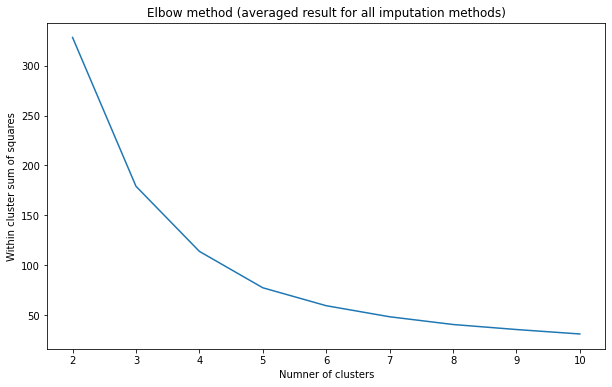

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), average_inertia)
plt.xlabel('Numner of clusters')
plt.ylabel('Within cluster sum of squares')
plt.title('Elbow method (averaged result for all imputation methods)');

According to the figure above, 5 clusters is the optimal for KMeans algorithm (the sum of sqaured errors begins to decrease significantly slower after 5 clusters)

In [6]:
for method in imputation_methods: 
    clusters['kmeans'][method] = pd.Series(
        KMeans(n_clusters=5).fit_predict(scale(df[method])),
        index=df[method].index
    )

## Hierarchical

We are going to keep the same number of clusters from now on.

In [7]:
for method in imputation_methods: 
    clusters['hierarchical'][method] = pd.Series(
        AgglomerativeClustering(n_clusters=5).fit_predict(scale(df[method])),
        index=df[method].index
    )

## Birch

In [8]:
for method in imputation_methods: 
    clusters['birch'][method] = pd.Series(
        Birch(n_clusters=5).fit_predict(np.ascontiguousarray(scale(df[method]))),
        index=df[method].index
    )

## Сlustering algorithms performance

In [9]:
scoring_metrics = ['silhouette', 'calinski_harabasz', 'mutual_info', 'rand']
scores = dict()

### Measures which do not require label

#### Silhouette score

In [10]:
scores['silhouette'] = pd.DataFrame(
    {
        clust_method: {
            method: silhouette_score(df[method], clusters[clust_method][method])
            for method in imputation_methods
        } for clust_method in clustering_methods
    }
)
scores['silhouette'].round(3)

,kmeans,hierarchical,birch
mean,0.500,0.487,0.473
median,0.483,0.504,0.464
ffil,0.488,0.480,0.461
bfil,0.483,0.438,0.423
regr,0.388,0.385,0.392
lint,0.500,0.475,0.485


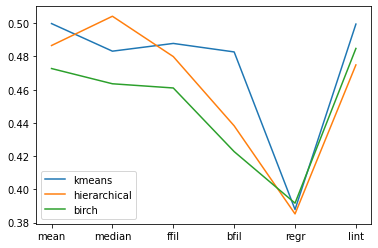

In [11]:
scores['silhouette'].plot();

#### Calinski and Harabasz score

In [12]:
scores['calinski_harabasz'] = pd.DataFrame(
    {
        clust_method: {
            method: calinski_harabasz_score(df[method], clusters[clust_method][method])
            for method in imputation_methods
        } for clust_method in clustering_methods
    }
)
scores['calinski_harabasz'].round(3)

,kmeans,hierarchical,birch
mean,328.186,294.443,314.054
median,319.951,309.380,269.223
ffil,306.426,292.213,263.433
bfil,309.393,236.565,251.434
regr,190.399,187.983,139.462
lint,318.013,270.089,279.680


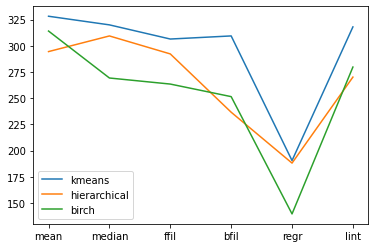

In [13]:
scores['calinski_harabasz'].plot();

### Measures which require label

#### Adjusted Mutual Info Score

In [14]:
scores['mutual_info'] = pd.DataFrame(
    {
        clust_method: {
            method: adjusted_mutual_info_score(
                income_group,
                clusters[clust_method][method].reindex(common_index)
            )
            for method in imputation_methods
        } for clust_method in clustering_methods
    }
)
scores['mutual_info'].round(3)

,kmeans,hierarchical,birch
mean,0.159,0.149,0.144
median,0.139,0.150,0.142
ffil,0.149,0.172,0.137
bfil,0.166,0.190,0.156
regr,0.147,0.151,0.131
lint,0.149,0.176,0.150


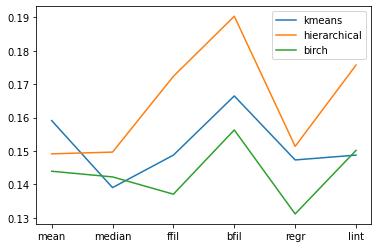

In [15]:
scores['mutual_info'].plot();

#### Adjusted Rand Score

In [16]:
scores['rand'] = pd.DataFrame(
    {
        clust_method: {
            method: adjusted_rand_score(
                income_group,
                clusters[clust_method][method].reindex(common_index)
            )
            for method in imputation_methods
        } for clust_method in clustering_methods
    }
)
scores['rand'].round(3)

,kmeans,hierarchical,birch
mean,0.111,0.122,0.112
median,0.107,0.134,0.144
ffil,0.102,0.103,0.142
bfil,0.113,0.168,0.109
regr,0.116,0.117,0.213
lint,0.102,0.119,0.139


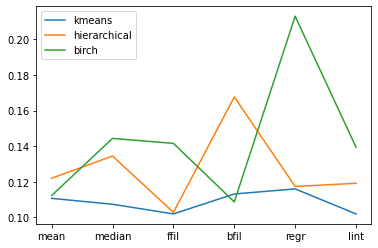

In [17]:
scores['rand'].plot();

## Select the best clustering method based on the clustering performance

Here, we are going to produce some metrics to estimate the performance and selected the best algorithm based on that estimation.

First of all, we are going to scale each scores, then compute average score for each alogithm

In [18]:
scaled_scores = dict()

for scoring_metric in scoring_metrics:
    scaled_scores[scoring_metric] = pd.DataFrame(
        minmax_scale(scores[scoring_metric].values.ravel()).reshape(6, 3),
        index=scores[scoring_metric].index,
        columns=scores[scoring_metric].columns
    )

In [19]:
averaged_imp_metods = pd.concat(
    [
        pd.Series(scaled_scores[scoring_metric].mean(), name=scoring_metric)
        for scoring_metric in scoring_metrics
    ],
    axis=1
)

averaged_imp_metods

,silhouette,calinski_harabasz,mutual_info,rand
kmeans,0.741788,0.826247,0.344999,0.059149
hierarchical,0.641227,0.665788,0.567908,0.227834
birch,0.539610,0.600977,0.208190,0.371674


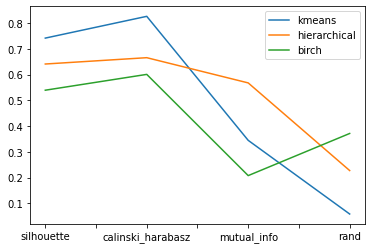

In [20]:
averaged_imp_metods.T.plot();

According to the figure above, KMeans achieves the highes values (on average) on unsupervised measures. Oppositely, it performs much worse on supervised measures. The Birch algorithm demonstrates the worst results on all metrics except the Adjusted Rand Score. The Hierarchical clustering demonstrates worse results on Silhouttee and Calinski Harabsz scores than KMeans, however it outperforms KMeans on measures which use ground truth. 

There are some possible reasons why KMeans does much better on the measures which do not require label. On the one hand, the number of optimal clusters was selected using the Elbow method based solely on the KMeans algorithm. On the other hand, the Silhouttee and Calinski Harabsz scoring measures conceptually are very similar to the loss (witihin cluster sum of squares) that the KMeans algorithm minimizes during learning process.

kmeans          0.493046
hierarchical    0.525689
birch           0.430113
dtype: float64

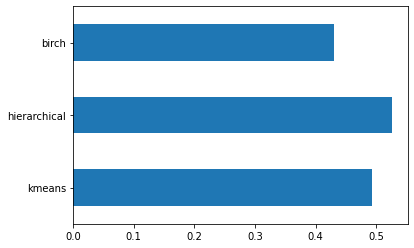

In [21]:
averaged_imp_metods.mean(axis=1).plot(kind='barh');
averaged_imp_metods.mean(axis=1)

Hierarchical clustering has the highest average value taken over all considered metrics.

Based on this fact and on that Hierarchical clustering has almost as high a unsupervised scores as the KMeans and shows complete superiority over KMeans on supervised scores, we select the Hierarchical clustering as the best clustering algorithm.

The best clustering algoritm: Hierarchical Clustering

### Find which data imputing method gives the best performance for clustering.  

In [22]:
averaged_imp_metods = pd.concat(
    [
        pd.Series(scaled_scores[scoring_metric].mean(axis=1), name=scoring_metric)
        for scoring_metric in scoring_metrics
    ],
    axis=1
)

averaged_imp_metods

,silhouette,calinski_harabasz,mutual_info,rand
mean,0.850090,0.915439,0.330672,0.117475
median,0.827239,0.848096,0.210991,0.241170
ffil,0.765184,0.783659,0.364481,0.121582
bfil,0.526757,0.669419,0.673829,0.251144
regr,0.025577,0.175668,0.204897,0.421865
lint,0.850404,0.793744,0.457326,0.164079


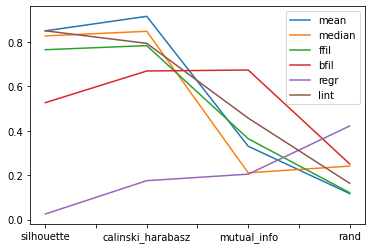

In [23]:
averaged_imp_metods.T.plot();

'Mean', 'Median', 'Forward fill', and 'Linear interpolation' imputing methods demonstrate higer performance than other methods on unsupervised metrics. However, on measures requiring label, higer scores are observed in 'Backward fill', and 'Linear Interpolation' (when considering both Adjusted Rand score and Adjusted Mutual Information score). For both supervised and unsupervised measures, a high score is observed only for the 'Linear Interpolation', however this is an extra method and we are not going to consider it for data imputation in further steps.

regr      0.207002
ffil      0.508726
bfil      0.530287
median    0.531874
mean      0.553419
lint      0.566388
dtype: float64

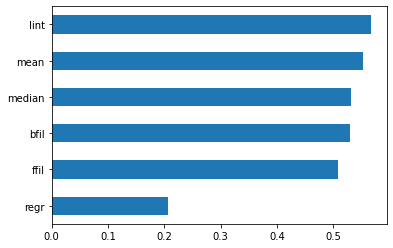

In [25]:
averaged_imp_metods.mean(axis=1).sort_values().plot(kind='barh');
averaged_imp_metods.mean(axis=1).sort_values()

'Mean' imputation method has the highest average value taken over all metrics after the linear interpolation.

The best data imputation method: Imputation by Mean.